# Initialization

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, when, regexp_extract, lit, mean, mode
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.sql.types import IntegerType
from pyspark.ml.stat import Correlation

conf = SparkConf().setAppName("EducationalDisparities").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

# Data Loading

In [ ]:
data_path = "WIDE.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Data exploration and cleaning

In [ ]:
# Data Exploration
print("Number of rows:", df.count(), "\n")
# print("Column names:", df.columns, "\n")

# print("Schema:")
# df.printSchema()

Number of rows: 146671 



In [ ]:
# Check for missing values
# print("\nMissing values:")
# df.select([col(c).isNull().alias(c) for c in df.columns]).show()

# Descriptive analysis

In [ ]:
# Drop rows with missing values in relevant columns
selected_columns = df.select(
    "year", "Sex", "Wealth", "Location",
    "eduout_prim_m", "eduout_lowsec_m", "eduout_upsec_m",
    "comp_prim_v2_m", "comp_lowsec_v2_m", "comp_upsec_v2_m",
    "attend_higher_1822_m",
    "overage2plus_m",
    "trans_prim_m", "trans_lowsec_m",
    "literacy_1524_m", "income_group"
)
print((selected_columns.count(), len(selected_columns.columns)))

(146671, 16)


In [ ]:
# Select the 'income_group' column and get distinct values
unique_income_groups = selected_columns.select("income_group").distinct()

# Show the unique values
unique_income_groups.show()

+--------------------+
|        income_group|
+--------------------+
|High income count...|
|Upper middle inco...|
|Low income countries|
|Lower middle inco...|
|                null|
+--------------------+



In [ ]:
# Define your a mapping of labels to indices
label_mapping = {
    "High income countries": 0,
    "Upper middle income countries": 1,
    "Lower middle income countries": 2,
    "Low income countries": 3,
}

In [ ]:
# Drop rows with missing values
selected_columns = selected_columns.dropna(thresh=15, subset=[
    "year", "Sex", "Wealth", "Location",
    "eduout_prim_m", "eduout_lowsec_m", "eduout_upsec_m",
    "comp_prim_v2_m", "comp_lowsec_v2_m", "comp_upsec_v2_m",
    "attend_higher_1822_m",
    "overage2plus_m",
    "trans_prim_m", "trans_lowsec_m",
    "literacy_1524_m"
])
print((selected_columns.count(), len(selected_columns.columns)))

# Fill missing values with the mean for numerical columns
numeric_cols = ['eduout_prim_m', 'eduout_lowsec_m', 'eduout_upsec_m', 'comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m', 'attend_higher_1822_m', 'overage2plus_m', 'trans_prim_m', 'trans_lowsec_m', 'literacy_1524_m']
for col_name in numeric_cols:
    mean_value = selected_columns.select(mean(col_name)).collect()[0][0]
    selected_columns = selected_columns.na.fill({col_name: mean_value})

# Fill missing values with the most frequent category for categorical columns
categorical_cols = ['Sex', 'Location', 'Wealth', 'income_group']
for col_name in categorical_cols:
    most_frequent_value = selected_columns.select(mode(col_name)).collect()[0][0][0]
    selected_columns = selected_columns.na.fill({col_name: most_frequent_value})


(1356, 16)


In [ ]:
# Convert columns with numeric data to the appropriate data types
selected_columns = selected_columns.withColumn("year", col("year").cast("int"))
selected_columns = selected_columns.withColumn("eduout_prim_m", col("eduout_prim_m").cast("float"))
selected_columns = selected_columns.withColumn("eduout_lowsec_m", col("eduout_lowsec_m").cast("float"))
selected_columns = selected_columns.withColumn("eduout_upsec_m", col("eduout_upsec_m").cast("float"))
selected_columns = selected_columns.withColumn("comp_prim_v2_m", col("comp_prim_v2_m").cast("float"))
selected_columns = selected_columns.withColumn("comp_lowsec_v2_m", col("comp_lowsec_v2_m").cast("float"))
selected_columns = selected_columns.withColumn("comp_upsec_v2_m", col("comp_upsec_v2_m").cast("float"))
selected_columns = selected_columns.withColumn("attend_higher_1822_m", col("attend_higher_1822_m").cast("float"))
selected_columns = selected_columns.withColumn("overage2plus_m", col("overage2plus_m").cast("float"))
selected_columns = selected_columns.withColumn("trans_prim_m", col("trans_prim_m").cast("float"))
selected_columns = selected_columns.withColumn("trans_lowsec_m", col("trans_lowsec_m").cast("float"))
selected_columns = selected_columns.withColumn("literacy_1524_m", col("literacy_1524_m").cast("float"))

# Create a new column 'isMale' based on the 'Sex' column
selected_columns = selected_columns.withColumn("isMale", when(col("Sex") == "Male", 1).otherwise(0))

# Extract the number from the 'Wealth' column using regexp_extract
selected_columns = selected_columns.withColumn("Wealth", regexp_extract(col("Wealth"), r'Quintile (\d+)', 1).cast("int"))

# Create a new column 'isRural' based on the 'Location' column
selected_columns = selected_columns.withColumn("isRural", when(col("Location") == "Rural", 1).otherwise(0))

# Use the 'when' function with 'lit' to assign custom index values to the 'income_group' column
selected_columns = selected_columns.withColumn("income_group_index", when(col("income_group") == lit("High income countries"), lit(label_mapping["High income countries"]))
                                       .when(col("income_group") == lit("Upper middle income countries"), lit(label_mapping["Upper middle income countries"]))
                                       .when(col("income_group") == lit("Lower middle income countries"), lit(label_mapping["Lower middle income countries"]))
                                       .when(col("income_group") == lit("Low income countries"), lit(label_mapping["Low income countries"]))
                                       .otherwise(None))

In [ ]:
# Remove any duplicate rows
selected_columns = selected_columns.dropDuplicates()

# Show the cleaned DataFrame
print("N° of columns:", len(selected_columns.columns))
selected_columns.show()

N° of columns: 19


+----+------+------+--------+-------------+---------------+--------------+--------------+----------------+---------------+--------------------+--------------+------------+--------------+---------------+--------------------+------+-------+------------------+
|year|   Sex|Wealth|Location|eduout_prim_m|eduout_lowsec_m|eduout_upsec_m|comp_prim_v2_m|comp_lowsec_v2_m|comp_upsec_v2_m|attend_higher_1822_m|overage2plus_m|trans_prim_m|trans_lowsec_m|literacy_1524_m|        income_group|isMale|isRural|income_group_index|
+----+------+------+--------+-------------+---------------+--------------+--------------+----------------+---------------+--------------------+--------------+------------+--------------+---------------+--------------------+------+-------+------------------+
|2010|Female|     5|   Urban|       0.1538|         0.3654|        0.6061|         0.565|          0.1782|          0.089|              0.0365|        0.1628|      0.8971|        0.7104|         0.6409|Low income countries|   

# Correlation analysis

In [ ]:
# Calculate the correlation matrix for numeric variables
numeric_columns = ["year", "isMale", "Wealth", "isRural",
    "eduout_prim_m", "eduout_lowsec_m", "eduout_upsec_m",
    "comp_prim_v2_m", "comp_lowsec_v2_m", "comp_upsec_v2_m",
    "attend_higher_1822_m", "overage2plus_m",
    "trans_prim_m", "trans_lowsec_m",
    "income_group_index", "literacy_1524_m"
]
correlation_results = {}
print("Total columns:", len(numeric_columns))
for idx1, col1 in enumerate(numeric_columns):
    for idx2, col2 in enumerate(numeric_columns):
        correlation_coefficient = selected_columns.corr(col1, col2)
        correlation_results[(col1, col2)] = correlation_coefficient
    print("["+str(idx1+1)+"/"+str(len(numeric_columns))+"]")

# Show the correlation results
# print("Correlation Results:")
# for (col1, col2), correlation_coefficient in correlation_results.items():
#     print(f"Correlation between {col1} and {col2}: {correlation_coefficient}")

Total columns: 16


[1/16]


[2/16]
[3/16]


[4/16]


[5/16]


[6/16]


[7/16]


[8/16]


[9/16]


[10/16]


[11/16]


[12/16]


[13/16]


[14/16]


[15/16]


[16/16]


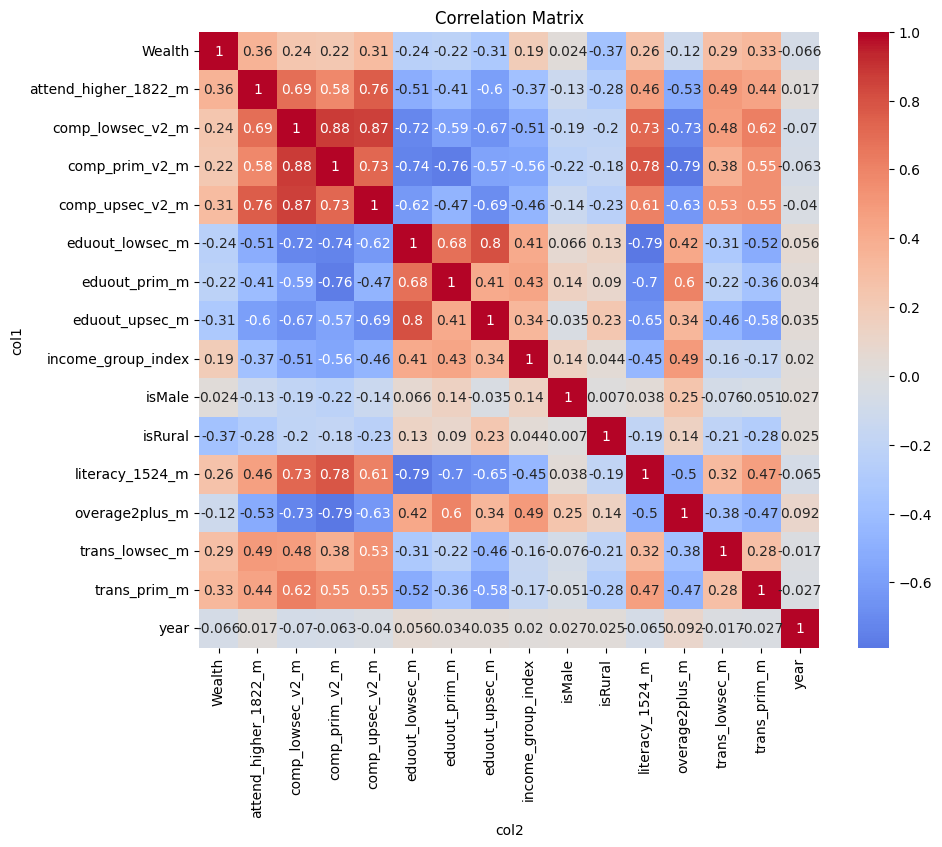

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the correlation results into a DataFrame
correlation_df = spark.createDataFrame([(key[0], key[1], value) for key, value in correlation_results.items()], ["col1", "col2", "correlation"])

# Convert the DataFrame to Pandas for visualization using seaborn
correlation_pandas = correlation_df.toPandas()

# Create a correlation matrix graph using seaborn
correlation_matrix = correlation_pandas.pivot(index="col1", columns="col2", values="correlation")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

# Predictive modeling

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

### "isMale" with multiple features


In [ ]:
# Create the VectorAssembler to combine features
assembler = VectorAssembler(inputCols=['overage2plus_m', 'literacy_1524_m', 'attend_higher_1822_m',
                                       'comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m'], outputCol='features')

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='isMale', numTrees=10)

# Create the pipeline for predicting 'isMale'
pipeline_is_male = Pipeline(stages=[assembler, rf_classifier])

# Fit the pipeline to the data
model_is_male = pipeline_is_male.fit(selected_columns)

# Make predictions
predictions_is_male = model_is_male.transform(selected_columns)
predictions_is_male.select('overage2plus_m',  'literacy_1524_m', 'comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m',
                           'attend_higher_1822_m', 'isMale', 'probability', 'prediction').show()

+--------------+---------------+--------------+----------------+---------------+--------------------+------+--------------------+----------+
|overage2plus_m|literacy_1524_m|comp_prim_v2_m|comp_lowsec_v2_m|comp_upsec_v2_m|attend_higher_1822_m|isMale|         probability|prediction|
+--------------+---------------+--------------+----------------+---------------+--------------------+------+--------------------+----------+
|        0.1628|         0.6409|         0.565|          0.1782|          0.089|              0.0365|     0|[0.77621909191751...|       0.0|
|        0.4054|         0.9555|        0.8679|          0.7073|         0.1839|              0.0963|     0|[0.63107269929293...|       0.0|
|        0.2028|            1.0|         0.733|          0.3726|         0.0209|              0.0025|     0|[0.69779729323580...|       0.0|
|        0.0335|            1.0|           1.0|          0.9843|         0.7671|              0.2063|     0|[0.82211184327292...|       0.0|
|        0.60

### "isRural" with multiple features

In [ ]:
# Create the VectorAssembler to combine features
assembler = VectorAssembler(inputCols=['comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m', 'attend_higher_1822_m',
                                       "trans_prim_m", "trans_lowsec_m"], outputCol='features')

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='isRural', numTrees=10)

# Create the pipeline for predicting 'isRural'
pipeline_is_rural = Pipeline(stages=[assembler, rf_classifier])

# Fit the pipeline to the data
model_is_rural = pipeline_is_rural.fit(selected_columns)

# Make predictions
predictions_is_rural = model_is_rural.transform(selected_columns)
predictions_is_rural.select('comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m', 'attend_higher_1822_m',
                            'trans_prim_m', 'trans_lowsec_m', 'isRural', 'probability', 'prediction').show()


+--------------+----------------+---------------+--------------------+------------+--------------+-------+--------------------+----------+
|comp_prim_v2_m|comp_lowsec_v2_m|comp_upsec_v2_m|attend_higher_1822_m|trans_prim_m|trans_lowsec_m|isRural|         probability|prediction|
+--------------+----------------+---------------+--------------------+------------+--------------+-------+--------------------+----------+
|         0.565|          0.1782|          0.089|              0.0365|      0.8971|        0.7104|      0|[0.73835530687569...|       0.0|
|        0.8679|          0.7073|         0.1839|              0.0963|      0.9529|        0.8244|      1|[0.66967592771744...|       0.0|
|         0.733|          0.3726|         0.0209|              0.0025|      0.9222|        0.5084|      0|[0.42159897009807...|       1.0|
|           1.0|          0.9843|         0.7671|              0.2063|         1.0|        0.8513|      0|[0.46880465556898...|       1.0|
|        0.2981|          0

### "Wealth" with multiple features

In [ ]:
# Create the VectorAssembler to combine features
assembler = VectorAssembler(inputCols=['eduout_prim_m', 'eduout_lowsec_m', 'eduout_upsec_m',
                                       'comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m',
                                       'attend_higher_1822_m', 'overage2plus_m'], outputCol='features')

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='Wealth', numTrees=10)

# Create the pipeline for predicting 'Wealth'
pipeline_wealth = Pipeline(stages=[assembler, rf_classifier])

# Fit the pipeline to the data
model_wealth = pipeline_wealth.fit(selected_columns)

# Make predictions
predictions_wealth = model_wealth.transform(selected_columns)
predictions_wealth.select('eduout_prim_m', 'eduout_lowsec_m', 'eduout_upsec_m', 'comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m', 'attend_higher_1822_m', 'overage2plus_m', 'Wealth', 'probability', 'prediction').show()

+-------------+---------------+--------------+--------------+----------------+---------------+--------------------+--------------+------+--------------------+----------+
|eduout_prim_m|eduout_lowsec_m|eduout_upsec_m|comp_prim_v2_m|comp_lowsec_v2_m|comp_upsec_v2_m|attend_higher_1822_m|overage2plus_m|Wealth|         probability|prediction|
+-------------+---------------+--------------+--------------+----------------+---------------+--------------------+--------------+------+--------------------+----------+
|       0.1538|         0.3654|        0.6061|         0.565|          0.1782|          0.089|              0.0365|        0.1628|     5|[0.0,0.1518673613...|       3.0|
|       0.1912|         0.0427|        0.2314|        0.8679|          0.7073|         0.1839|              0.0963|        0.4054|     4|[0.0,0.0975926107...|       4.0|
|       0.1307|         0.2071|        0.4804|         0.733|          0.3726|         0.0209|              0.0025|        0.2028|     3|[0.0,0.127179

### "income_group_index" with multiple features

In [ ]:
# Create the VectorAssembler to combine features
assembler = VectorAssembler(inputCols=['eduout_prim_m', 'eduout_lowsec_m', 'eduout_upsec_m',
                                       'comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m', 'attend_higher_1822_m',
                                       'overage2plus_m', 'trans_prim_m', 'trans_lowsec_m', 'literacy_1524_m'], outputCol='features')

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='income_group_index', numTrees=10)

# Create the pipeline for predicting 'income_group_index'
pipeline_income_group = Pipeline(stages=[assembler, rf_classifier])

# Fit the pipeline to the data
model_income_group = pipeline_income_group.fit(selected_columns)

# Make predictions
predictions_income_group = model_income_group.transform(selected_columns)
predictions_income_group.select('eduout_prim_m', 'eduout_lowsec_m', 'eduout_upsec_m', 'comp_prim_v2_m', 'comp_lowsec_v2_m', 'comp_upsec_v2_m', 'attend_higher_1822_m', 'overage2plus_m', 'trans_prim_m', 'trans_lowsec_m', 'literacy_1524_m', 'income_group_index', 'probability', 'prediction').show()


+-------------+---------------+--------------+--------------+----------------+---------------+--------------------+--------------+------------+--------------+---------------+------------------+--------------------+----------+
|eduout_prim_m|eduout_lowsec_m|eduout_upsec_m|comp_prim_v2_m|comp_lowsec_v2_m|comp_upsec_v2_m|attend_higher_1822_m|overage2plus_m|trans_prim_m|trans_lowsec_m|literacy_1524_m|income_group_index|         probability|prediction|
+-------------+---------------+--------------+--------------+----------------+---------------+--------------------+--------------+------------+--------------+---------------+------------------+--------------------+----------+
|       0.1538|         0.3654|        0.6061|         0.565|          0.1782|          0.089|              0.0365|        0.1628|      0.8971|        0.7104|         0.6409|                 3|[0.0,0.0477317852...|       3.0|
|       0.1912|         0.0427|        0.2314|        0.8679|          0.7073|         0.1839|  

# Results display

### "isMale" and multiple features

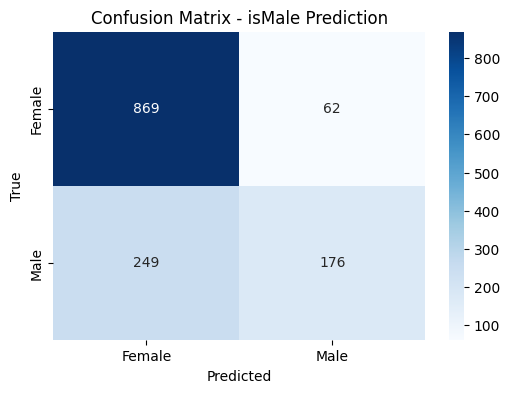

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for 'isMale'
true_labels = predictions_is_male.select('isMale').rdd.flatMap(lambda x: x).collect()
predicted_labels = predictions_is_male.select('prediction').rdd.flatMap(lambda x: x).collect()

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - isMale Prediction')
plt.show()


### "isRural" with multiple features

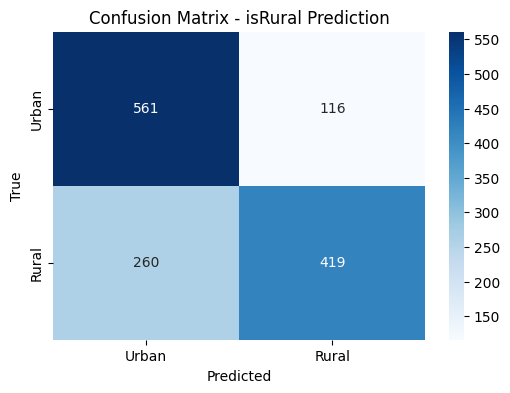

In [ ]:
# Get the true labels and predicted labels for 'isRural'
true_labels_rural = predictions_is_rural.select('isRural').rdd.flatMap(lambda x: x).collect()
predicted_labels_rural = predictions_is_rural.select('prediction').rdd.flatMap(lambda x: x).collect()

# Create the confusion matrix
cm_rural = confusion_matrix(true_labels_rural, predicted_labels_rural)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rural, annot=True, fmt='d', cmap='Blues', xticklabels=['Urban', 'Rural'], yticklabels=['Urban', 'Rural'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - isRural Prediction')
plt.show()


### "Wealth" with multiple features

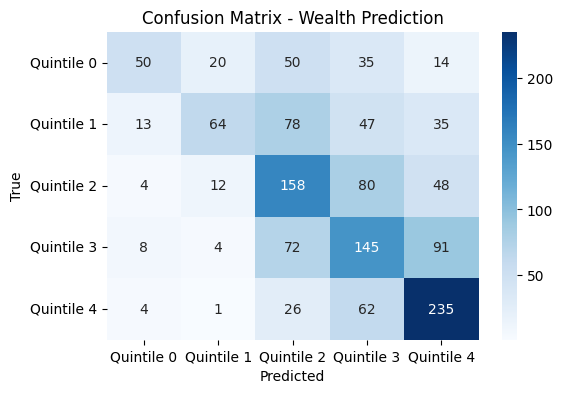

In [ ]:
# Get the true labels and predicted labels for 'Wealth'
true_labels_wealth = predictions_wealth.select('Wealth').rdd.flatMap(lambda x: x).collect()
predicted_labels_wealth = predictions_wealth.select('prediction').rdd.flatMap(lambda x: x).collect()

# Create the confusion matrix
cm_wealth = confusion_matrix(true_labels_wealth, predicted_labels_wealth)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_wealth, annot=True, fmt='d', cmap='Blues', xticklabels=['Quintile 0', 'Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4'], yticklabels=['Quintile 0', 'Quintile 1', 'Quintile 2', 'Quintile 3', 'Quintile 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Wealth Prediction')
plt.show()


### "income_group_index" with multiple features

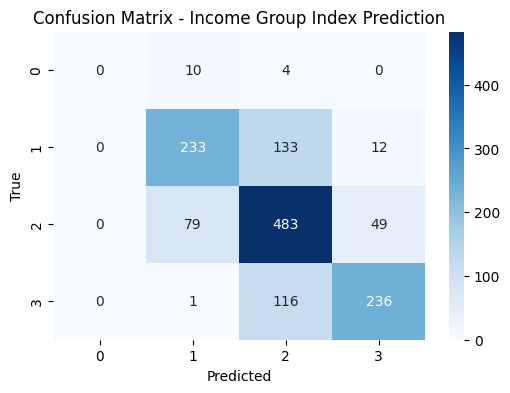

In [ ]:
# Get the true labels and predicted labels for 'income_group_index'
true_labels_income_group = predictions_income_group.select('income_group_index').rdd.flatMap(lambda x: x).collect()
predicted_labels_income_group = predictions_income_group.select('prediction').rdd.flatMap(lambda x: x).collect()

# Create the confusion matrix
cm_income_group = confusion_matrix(true_labels_income_group, predicted_labels_income_group)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_income_group, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Income Group Index Prediction')
plt.show()


### Stop Spark

In [ ]:
# Detener el contexto de Spark
spark.stop()

# Interpretation and conclusions

### Interpretation:

1. "isMale" Prediction:
The "isMale" prediction model aims to predict the gender of individuals based on the variables "overage2plus_m", "literacy_1524_m", "attend_higher_1822_m", "comp_prim_v2_m", "comp_lowsec_v2_m" and "comp_upsec_v2_m". The confusion matrix shows the performance of the model in classifying individuals as male or female. The model seems to have achieved reasonably accurate predictions, as indicated by the relatively high number of true positives and true negatives, but appears to be more accurate in predicting males than females.

2. "isRural" Prediction:
The "isRural" prediction model aims to predict whether individuals are from rural or urban areas based on the variables "comp_prim_v2_m", "comp_lowsec_v2_m", "comp_upsec_v2_m", "attend_higher_1822_m", "trans_prim_m" and "trans_lowsec_m". The confusion matrix demonstrates how well the model performs in distinguishing between rural and urban individuals. The model appears to have achieved moderate success, with a reasonable number of true positives and true negatives, but appears to be more accurate in predicting urban records than rural ones.

3. "Wealth" Prediction:
The "Wealth" prediction model attempts to predict the wealth quintile of individuals based on various educational indicators, such as "eduout_prim_m", "eduout_lowsec_m", "eduout_upsec_m", "comp_prim_v2_m", "comp_lowsec_v2_m", "comp_upsec_v2_m", "attend_higher_1822_m", "overage2plus_m". The confusion matrix showcases the model's performance in classifying individuals into different wealth quintiles. The model shows a moderate level of success, with notable true positives and true negatives.

4. "income_group_index" Prediction:
The "income_group_index" prediction model aims to predict the income group of countries based on various educational indicators, such as "eduout_prim_m," "comp_lowsec_v2_m," "trans_lowsec_m," and others. The confusion matrix depicts the model's performance in classifying countries into different income groups. The model exhibits some level of success, though further improvements may be required.

### Conclusions:

1. Gender Prediction:
The "isMale" prediction model shows promising results in predicting the gender of individuals based on literacy rates. However, further investigations could be conducted to explore additional features that may contribute to gender prediction with higher accuracy.

2. Rural/Urban Prediction:
The "isRural" prediction model demonstrates moderate success in predicting whether individuals are from rural or urban areas based on educational indicators. Further refinement of the model and consideration of other relevant variables could enhance its accuracy.

3. Wealth Quintile Prediction:
The "Wealth" prediction model shows moderate performance in predicting the wealth quintile of individuals based on their educational outcomes. Fine-tuning the model and incorporating additional socioeconomic factors could lead to improved predictions.

4. Income Group Prediction:
The "income_group_index" prediction model exhibits some success in classifying countries into income groups based on educational indicators. However, more extensive data and advanced modeling techniques may be needed to achieve higher accuracy.

Predictive modeling can provide valuable insights into educational disparities and socioeconomic factors. The presented models offer a foundation for further exploration and refinement. As the project progresses, more sophisticated techniques and feature engineering could be employed to improve model accuracy and gain deeper insights into the relationship between education and socioeconomic dynamics. Continuous exploration and evaluation of the models will lead to more informed decisions and actionable recommendations to address educational disparities and foster social and economic development.